<a href="https://colab.research.google.com/github/OksanaBut77/TFM/blob/main/TFM_Complete_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, cdist
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [370]:
df_member_cluster = pd.read_csv('/content/drive/MyDrive/TFM/df_member_base.csv')
print(df_member_cluster.head(5))

   depart_id  card_id  member_class    last_consume_time  card_type  \
0     270297  1936560          3407                  NaN          0   
1     270297  3208730          1515  2020-01-22 09:18:15          0   
2     270155  4053650          1700  2021-11-13 09:57:18          0   
3     270155  4053950          1672  2021-12-05 18:49:25          0   
4     270297  4133810          3407                  NaN          0   

   define_class  is_suff  level    birthday  consume_level  point  \
0           170        0      2  1968-12-01              1    0.0   
1           426        0      2  1954-07-24              1    0.0   
2           578        0      3  2016-09-02              1    0.0   
3           287        0      3  1951-09-13              1    0.0   
4           170        0      2  2015-12-28              1    0.0   

            updatetime  sex   age  Recency  
0  2021-09-13 06:18:05  0.0  53.0      NaN  
1  2021-09-13 06:18:05  0.0  67.0    599.0  
2  2021-11-28 05:31:55 

In [371]:
df_member_cluster.columns

Index(['depart_id', 'card_id', 'member_class', 'last_consume_time',
       'card_type', 'define_class', 'is_suff', 'level', 'birthday',
       'consume_level', 'point', 'updatetime', 'sex', 'age', 'Recency'],
      dtype='object')

In [372]:
df_member_cluster.shape

(10000, 15)

In [373]:
nan_percentages_member = (df_member_cluster.isna().mean() * 100).sort_values(ascending=False)
print(nan_percentages_member)

last_consume_time    57.86
Recency              57.86
sex                  32.49
age                   0.06
birthday              0.06
card_id               0.00
depart_id             0.00
is_suff               0.00
define_class          0.00
card_type             0.00
member_class          0.00
point                 0.00
consume_level         0.00
level                 0.00
updatetime            0.00
dtype: float64


In [374]:
df_member_cluster['last_consume_time'].fillna(df_member_cluster['updatetime'], inplace=True)

<ipython-input-374-fcbcd4ea0f4c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_member_cluster['last_consume_time'].fillna(df_member_cluster['updatetime'], inplace=True)


In [375]:
# columnas con outliers
numeric_cols = ['age', 'point']

df_member_clean = df_member_cluster.copy()

for col in numeric_cols:
    Q1 = df_member_clean[col].quantile(0.25)
    Q3 = df_member_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtramos los datos fuera del rango
    df_member_clean = df_member_clean[
        (df_member_clean[col] >= lower_bound) & (df_member_clean[col] <= upper_bound)
    ]

In [376]:
df_member_clean.shape

(8481, 15)

In [377]:
mean_age = df_member_clean["age"].mean()

df_member_clean.loc[df_member_clean["age"] < 17, "age"] = mean_age
mean_age = round(df_member_clean["age"].mean())

In [378]:
df_member_clean["age"].describe()

,age
count,8481.000000
mean,34.256340
std,16.148283
min,17.000000
25%,24.000000
50%,24.000000
75%,37.000000
max,79.000000


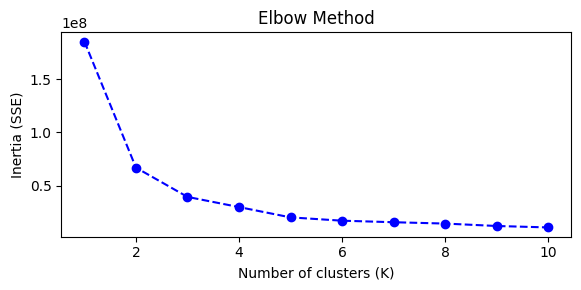

In [379]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Lista para valores de la inercia (SSE)
inertia = []

# Número de clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_member_clean[['define_class', 'is_suff', 'level', 'consume_level', 'point', 'age']])
    inertia.append(kmeans.inertia_)

# Gráfico del método del codo
plt.figure(figsize=(6, 3))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.tight_layout()
plt.show()

In [380]:
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_member_clean[['define_class', 'is_suff', 'level', 'consume_level', 'point', 'age']])

clustering_algorithms = {
    "K-Means (3 clusters)": KMeans(n_clusters=3, random_state=42),
    "K-Means (4 clusters)": KMeans(n_clusters=4, random_state=42),
    "Mean-Shift": MeanShift(),
    "Agglomerative Clustering": AgglomerativeClustering(),
    "DBSCAN": DBSCAN(),
    "GMM": GaussianMixture(n_components=4, random_state=42)
}

#  lista métricas
metrics_data = []

# Clustering y evaluación
for name, algorithm in clustering_algorithms.items():
    algorithm.fit(df_normalized)

    # Predicción de etiquetas
    labels = algorithm.labels_ if hasattr(algorithm, 'labels_') else algorithm.predict(df_normalized)

    # métricas
    sil_score = silhouette_score(df_normalized, labels)
    ch_score = calinski_harabasz_score(df_normalized, labels)
    db_score = davies_bouldin_score(df_normalized, labels)

    # resultados
    metrics_data.append([sil_score, ch_score, db_score])

# DataFrame con los resultados
metrics_df = pd.DataFrame(metrics_data, columns=["Silhouette Score", "Calinski-Harabasz", "Davies-Bouldin"],
                          index=clustering_algorithms.keys())

print(metrics_df)

                          Silhouette Score  Calinski-Harabasz  Davies-Bouldin
K-Means (3 clusters)              0.617801        3191.869251        1.274137
K-Means (4 clusters)              0.660912        3168.424106        1.066105
Mean-Shift                        0.707130        1627.974304        0.761820
Agglomerative Clustering          0.554817        3161.797355        1.213709
DBSCAN                            0.494605         317.356478        1.423389
GMM                               0.598063        3824.766953        0.766933


In [381]:
# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_member_clean['Cluster KMeans'] = kmeans.fit_predict(df_normalized)

print(df_member_clean['Cluster KMeans'].value_counts())


Cluster KMeans
0    5589
1    2880
2      12
Name: count, dtype: int64


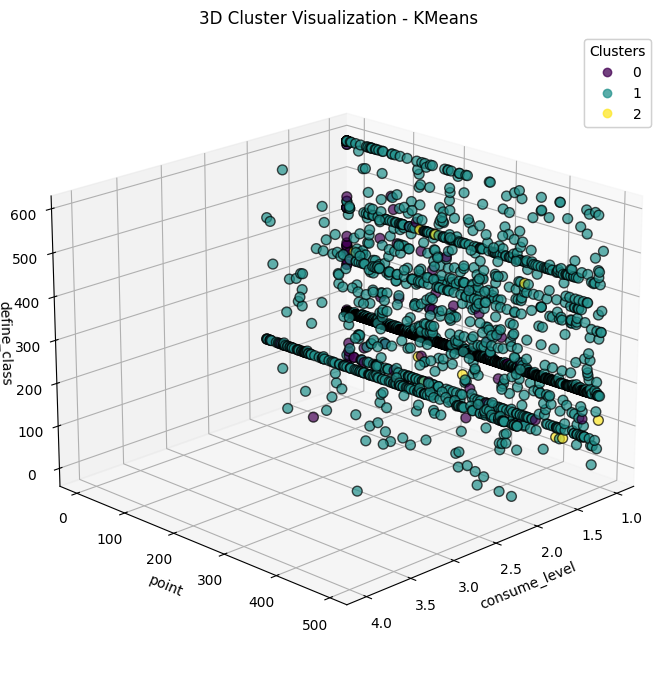

In [382]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

x = df_member_clean['consume_level']
y = df_member_clean['point']
z = df_member_clean['define_class']
clusters = df_member_clean['Cluster KMeans']

scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', edgecolors='k', s=50, alpha=0.7)

ax.set_xlabel("consume_level")
ax.set_ylabel("point")
ax.set_zlabel("define_class", labelpad=0)
ax.set_title("3D Cluster Visualization - KMeans")

ax.view_init(elev=20, azim=45)

fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="best")
ax.add_artist(legend1)

plt.show()

In [383]:
from sklearn.cluster import MeanShift

# Mean-Shift
meanshift = MeanShift()
df_member_clean['Cluster MeanShift'] = meanshift.fit_predict(df_normalized)

# cantidad en cada cluster
print(df_member_clean['Cluster MeanShift'].value_counts())

Cluster MeanShift
0     4808
1     1750
2      770
3      275
6      147
5      117
4       90
17      87
9       69
7       68
8       46
13      42
10      35
11      35
12      30
14      27
15      25
16      17
20       9
19       7
18       6
21       3
23       2
22       2
26       1
31       1
27       1
36       1
28       1
33       1
29       1
30       1
34       1
37       1
35       1
24       1
25       1
32       1
Name: count, dtype: int64


In [384]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
#  Agglomerative Clustering
n_clusters = 3
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_member_clean['Cluster Agglom'] = agg_clustering.fit_predict(df_normalized)

print(df_member_clean['Cluster Agglom'].value_counts())

Cluster Agglom
1    5585
0    2884
2      12
Name: count, dtype: int64


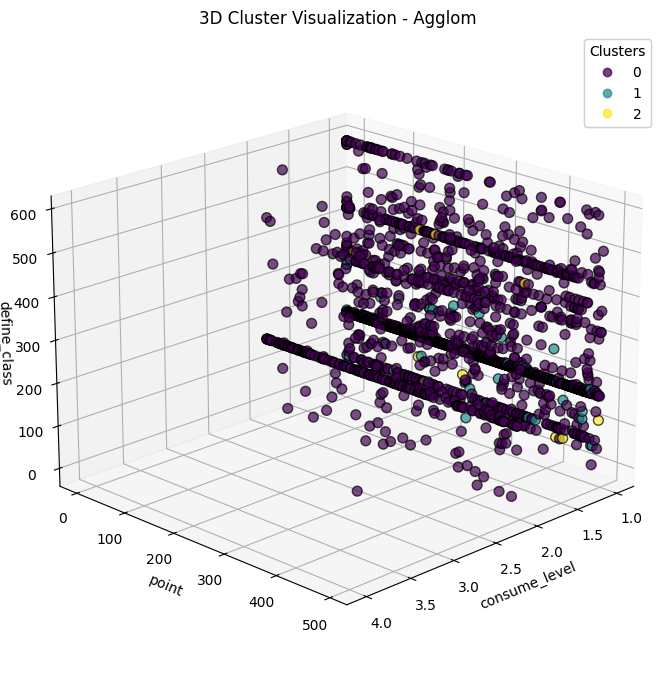

In [385]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

x = df_member_clean['consume_level']
y = df_member_clean['point']
z = df_member_clean['define_class']
clusters = df_member_clean['Cluster Agglom']

scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', edgecolors='k', s=50, alpha=0.7)

ax.set_xlabel("consume_level")
ax.set_ylabel("point")
ax.set_zlabel("define_class", labelpad=0)
ax.set_title("3D Cluster Visualization - Agglom")

ax.view_init(elev=20, azim=45)

fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="best")
ax.add_artist(legend1)

plt.show()

In [386]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(df_member_clean['Cluster KMeans'], df_member_clean['Cluster Agglom'])
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.967


In [387]:
df_member_clean.head(5)

,depart_id,card_id,member_class,last_consume_time,card_type,define_class,is_suff,level,birthday,consume_level,point,updatetime,sex,age,Recency,Cluster KMeans,Cluster MeanShift,Cluster Agglom
0,270297,1936560,3407,2021-09-13 06:18:05,0,170,0,2,1968-12-01,1,0.0,2021-09-13 06:18:05,0.0,53.000000,NaN,0,2,1
1,270297,3208730,1515,2020-01-22 09:18:15,0,426,0,2,1954-07-24,1,0.0,2021-09-13 06:18:05,0.0,67.000000,599.0,1,11,0
2,270155,4053650,1700,2021-11-13 09:57:18,0,578,0,3,2016-09-02,1,0.0,2021-11-28 05:31:55,1.0,31.622804,14.0,0,18,0
3,270155,4053950,1672,2021-12-05 18:49:25,0,287,0,3,1951-09-13,1,0.0,2021-12-14 05:57:15,1.0,70.000000,8.0,0,11,0
4,270297,4133810,3407,2021-09-13 06:18:05,0,170,0,2,2015-12-28,1,0.0,2021-09-13 06:18:05,0.0,31.622804,NaN,0,0,1


In [388]:
df_member_clean.columns

Index(['depart_id', 'card_id', 'member_class', 'last_consume_time',
       'card_type', 'define_class', 'is_suff', 'level', 'birthday',
       'consume_level', 'point', 'updatetime', 'sex', 'age', 'Recency',
       'Cluster KMeans', 'Cluster MeanShift', 'Cluster Agglom'],
      dtype='object')

Cambio de cluster

In [389]:
df_member_change = pd.read_csv('/content/drive/MyDrive/TFM/df_all_clusters_2016_2021.csv', sep=';')
print(df_member_change.head(5))

   card_id  cluster_16_17  cluster_17_18  cluster_18_19  cluster_19_20  \
0   486539            NaN            NaN            NaN            NaN   
1  4999100            NaN            NaN            NaN            1.0   
2   565205            0.0            NaN            NaN            NaN   
3    74083            NaN            NaN            NaN            NaN   
4    89416            NaN            NaN            NaN            NaN   

   cluster_20_21  cambio de cluster  
0            1.0                  1  
1            0.0                  1  
2            NaN                  0  
3            1.0                  1  
4            1.0                  1  


In [390]:
df_member_model = df_member_clean.merge(
    df_member_change[['card_id', 'cambio de cluster', 'cluster_19_20', 'cluster_20_21']],
    on='card_id',
    how='left'
)

In [391]:
# df_member_model

In [392]:
porcentaje_1 = (df_member_model['cambio de cluster'] == 1).mean() * 100
print(f"Porcentaje de 1 en 'cambio_de_cluster': {porcentaje_1:.2f}%")

Porcentaje de 1 en 'cambio_de_cluster': 5.15%


In [393]:
df_member_model['cambio de cluster'] = df_member_model['cambio de cluster'].fillna(0)

In [394]:
df_member_model.columns

Index(['depart_id', 'card_id', 'member_class', 'last_consume_time',
       'card_type', 'define_class', 'is_suff', 'level', 'birthday',
       'consume_level', 'point', 'updatetime', 'sex', 'age', 'Recency',
       'Cluster KMeans', 'Cluster MeanShift', 'Cluster Agglom',
       'cambio de cluster', 'cluster_19_20', 'cluster_20_21'],
      dtype='object')

In [395]:
df_member_model.shape

(8481, 21)

In [396]:
df_member_model = df_member_model[['depart_id', 'card_id', 'is_suff', 'level',
                                   'birthday', 'consume_level', 'point',
                                   'updatetime', 'cambio de cluster', "age"]]

In [397]:
df_member_model.shape

(8481, 10)

Logistic Regression

In [398]:
df_member_model.columns

Index(['depart_id', 'card_id', 'is_suff', 'level', 'birthday', 'consume_level',
       'point', 'updatetime', 'cambio de cluster', 'age'],
      dtype='object')

In [399]:
# Preparación de los datos
X = df_member_model.drop(columns=['depart_id', 'card_id', 'updatetime', 'cambio de cluster', 'birthday'])
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.median(numeric_only=True))

y = df_member_model['cambio de cluster']

# Definición del pipeline con escalado, SMOTE y modelo
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('log_reg', LogisticRegression(random_state=42, max_iter=1000))
])

# Validación cruzada estratificada con 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluación con métricas ROC AUC y Accuracy
scores = cross_validate(
    pipeline,
    X,
    y,
    cv=cv,
    scoring=['roc_auc', 'accuracy'],
    return_train_score=False
)

# Mostrar resultados promedio de validación cruzada
print(f"ROC AUC (CV promedio): {scores['test_roc_auc'].mean():.4f}")
print(f"Accuracy (CV promedio): {scores['test_accuracy'].mean():.2f}")

# Entrenamiento final sobre el conjunto de entrenamiento + evaluación en test (opcional)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Escalar y aplicar SMOTE solo a los datos de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

# Entrenar modelo final
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_res, y_res)

# Evaluar en el conjunto de test
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)

print("\n--- Evaluación final en conjunto de test ---")
print(f'ROC AUC (test): {roc_auc:.4f}')
print(f'Accuracy (test): {accuracy:.2f}')
print(classification_report(y_test, y_pred))

ROC AUC (CV promedio): 0.8693
Accuracy (CV promedio): 0.82

--- Evaluación final en conjunto de test ---
ROC AUC (test): 0.8583
Accuracy (test): 0.82
              precision    recall  f1-score   support

         0.0       0.98      0.82      0.90      2414
         1.0       0.18      0.69      0.28       131

    accuracy                           0.82      2545
   macro avg       0.58      0.76      0.59      2545
weighted avg       0.94      0.82      0.86      2545



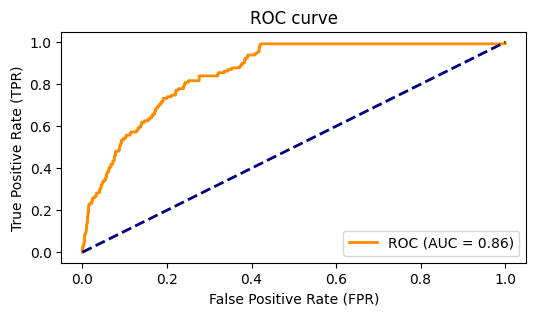

In [400]:
# curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular el AUC
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (sin discriminación)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

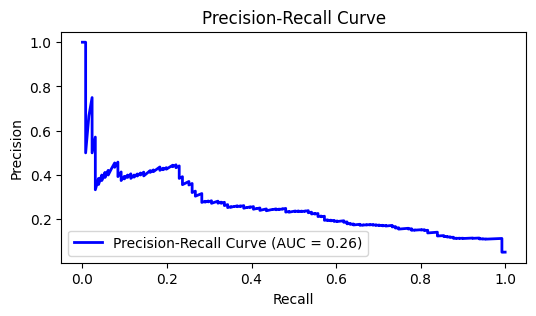

In [401]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Calcular la curva de precisión-recuperación
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)

# Calcular el AUC para la curva de precisión-recuperación
pr_auc = average_precision_score(y_test, y_prob)

# Graficar la curva de precisión-recuperación Area under Curve
plt.figure(figsize=(6, 3))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [402]:
# Predicción de la probabilidad de cambio de cluster
nuevos_datos = X_test_scaled
probabilidad_cambio = log_reg.predict_proba(nuevos_datos)[:, 1]

print(probabilidad_cambio)

[0.37335288 0.54072487 0.3995097  ... 0.1817903  0.1817903  0.70521625]


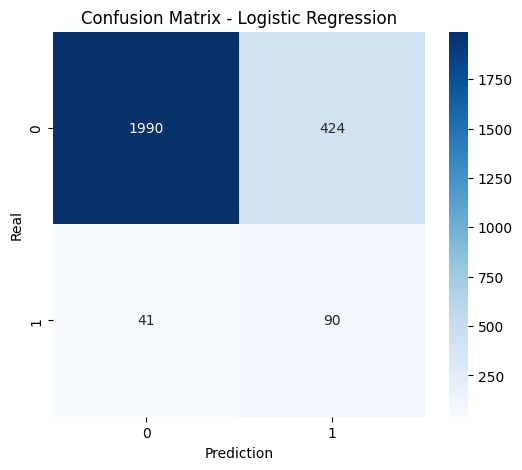

In [403]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [404]:
# Crear un modelo de regresión logística con regularización L2 (Ridge)
log_reg_ridge = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
log_reg_ridge.fit(X_train_scaled, y_train)

# Evaluar precisión
train_accuracy_ridge = log_reg_ridge.score(X_train_scaled, y_train)
test_accuracy_ridge = log_reg_ridge.score(X_test_scaled, y_test)

print(f'Precisión con regularización L2 (Ridge) en entrenamiento: {train_accuracy_ridge:.4f}')
print(f'Precisión con regularización L2 (Ridge) en prueba: {test_accuracy_ridge:.4f}')


Precisión con regularización L2 (Ridge) en entrenamiento: 0.9456
Precisión con regularización L2 (Ridge) en prueba: 0.9470


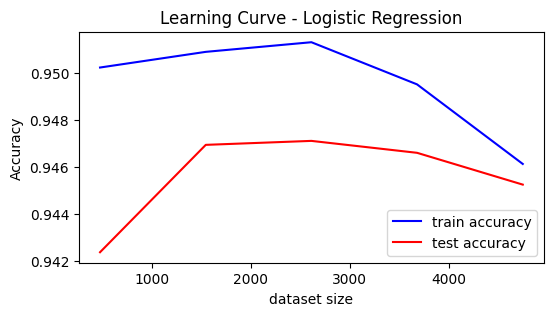

In [405]:
from sklearn.model_selection import learning_curve

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Promediar las puntuaciones de precisión
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(6, 3))
plt.plot(train_sizes, train_mean, label='train accuracy', color='b')
plt.plot(train_sizes, test_mean, label='test accuracy', color='r')
plt.xlabel('dataset size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Logistic Regression')
plt.legend(loc='best')
plt.show()

Random Forest

In [406]:
# Entrenar modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Validación cruzada
cv_scores_rf = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print(f'ROC AUC (CV average): {cv_scores_rf.mean():.4f}')

# Entrenar
rf.fit(X_train_scaled, y_train)

# Predicciones
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Métricas en el conjunto de prueba
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f'ROC AUC (test): {roc_auc_rf:.4f}')
print(f'Accuracy (test): {accuracy_rf:.2f}')
print(classification_report(y_test, y_pred_rf))

ROC AUC (CV average): 0.9464
ROC AUC (test): 0.9498
Accuracy (test): 0.96
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2414
         1.0       0.66      0.54      0.59       131

    accuracy                           0.96      2545
   macro avg       0.82      0.76      0.79      2545
weighted avg       0.96      0.96      0.96      2545



In [407]:
# importancia de las características
importances = rf.feature_importances_

# DataFrame con las importancias
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Ordenar las características por su importancia (de mayor a menor)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

         Feature  Importance
3          point    0.379526
4            age    0.348395
1          level    0.204637
2  consume_level    0.066211
0        is_suff    0.001231


In [408]:
# Filtrar las 10 características más importantes
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

<ipython-input-409-186bdbc62e37>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


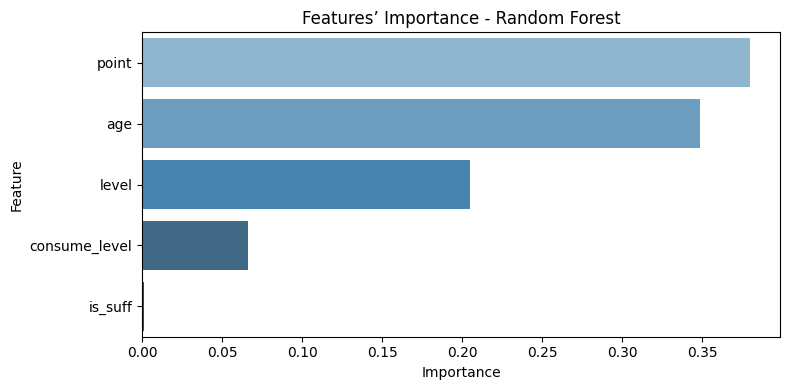

In [409]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
plt.title('Features’ Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

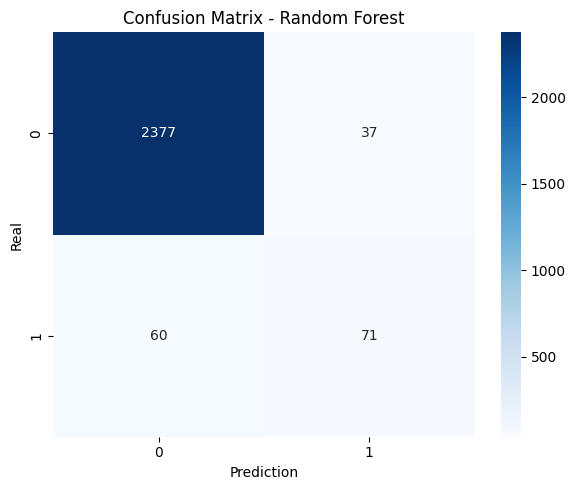

In [418]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'], yticklabels=['0', '1'],
            annot_kws={"size": 10})  # Tamaño de texto opcional
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()  # Evita solapamiento
plt.show()

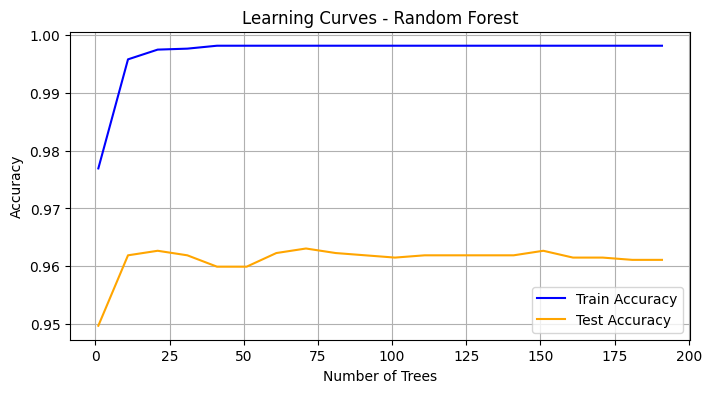

In [411]:
# almacenar resultados
train_accuracy = []
test_accuracy = []

# Entrenar el modelo con un número creciente de árboles
n_estimators_range = range(1, 201, 10)

for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)

    # Predecir y evaluar precisión
    train_accuracy.append(accuracy_score(y_train, rf.predict(X_train)))
    test_accuracy.append(accuracy_score(y_test, rf.predict(X_test)))

plt.figure(figsize=(8, 4))
plt.plot(n_estimators_range, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(n_estimators_range, test_accuracy, label='Test Accuracy', color='orange')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Learning Curves - Random Forest')
plt.legend()
plt.grid(True)
plt.show()

Shapley value

In [412]:
!pip install shap

In [413]:
import shap

# objeto explicador SHAP
explainer = shap.TreeExplainer(rf)

# valores SHAP
shap_values = explainer.shap_values(X_test_scaled)

# Para este formato específico (3000, 10, 2), necesitamos extraer los valores para la clase positiva
# Este formato parece ser: [muestras, características, clases]
# Extraemos los valores para la clase positiva (índice 1) de todas las muestras y características
shap_values_class1 = shap_values[:, :, 1]

#  importancia de características basada en valores SHAP absolutos para la clase positiva
shap_importance = np.abs(shap_values_class1).mean(axis=0)

# DataFrame con importancias SHAP
shap_df = pd.DataFrame({
    'Feature': X.columns,
    'SHAP Value': shap_importance
})

# Ordenar por importancia de SHAP
shap_df = shap_df.sort_values(by='SHAP Value', ascending=False)
print("\nTop 10 características según valores SHAP:")
print(shap_df.head(10))

#  plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_scaled, feature_names=X.columns.tolist(), show=False)
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
plt.close()

# característica más importante según SHAP
most_important_feature = shap_df.iloc[0]['Feature']
feature_idx = list(X.columns).index(most_important_feature)
plt.figure(figsize=(10, 6))
shap.dependence_plot(feature_idx, shap_values_class1, X_test_scaled,
                    feature_names=X.columns.tolist(), show=False)
plt.tight_layout()
plt.savefig(f'shap_dependence_plot_{most_important_feature}.png')
plt.close()

#  rankings de importancia
print("\nComparación de rankings de importancia:")
comparison_df = pd.merge(importance_df, shap_df, on='Feature')
comparison_df = comparison_df.rename(columns={
    'Importance': 'Random Forest Importance',
    'SHAP Value': 'SHAP Importance'
})
comparison_df['RF Rank'] = comparison_df['Random Forest Importance'].rank(ascending=False)
comparison_df['SHAP Rank'] = comparison_df['SHAP Importance'].rank(ascending=False)
comparison_df['Rank Difference'] = abs(comparison_df['RF Rank'] - comparison_df['SHAP Rank'])
comparison_df = comparison_df.sort_values(by='SHAP Importance', ascending=False)

print(comparison_df.head(10))

# Explicación para un ejemplo individual
sample_idx = 0
print(f"\nExplicación SHAP para el ejemplo #{sample_idx}:")

# Extraer valores SHAP para el ejemplo específico y la clase positiva
sample_shap_values = shap_values[sample_idx, :, 1]

sample_explanation = pd.DataFrame({
    'Feature': X.columns,
    'SHAP Value': sample_shap_values
})
sample_explanation = sample_explanation.sort_values(by='SHAP Value', ascending=False)
print(sample_explanation.head(10))

# explicación para  ejemplo
plt.figure(figsize=(10, 6))
shap.force_plot(
    explainer.expected_value[1],  # Valor base para la clase positiva
    sample_shap_values,
    X_test_scaled[sample_idx],
    feature_names=X.columns.tolist(),
    matplotlib=True,
    show=False
)
plt.tight_layout()
plt.savefig('shap_force_plot_example.png')
plt.close()

# Generar SHAP waterfall
plt.figure(figsize=(10, 12))
shap.plots.waterfall(
    shap.Explanation(
        values=sample_shap_values,
        base_values=explainer.expected_value[1],
        data=X_test_scaled[sample_idx],
        feature_names=X.columns.tolist()
    ),
    show=False
)
plt.tight_layout()
plt.savefig('shap_waterfall_plot_example.png')
plt.close()

print("\nVisualizaciones de explicación individual guardadas.")

# matriz de dependencia para ver las interacciones entre características
plt.figure(figsize=(12, 10))
top_features = shap_df['Feature'].head(6).tolist()
top_indices = [list(X.columns).index(feat) for feat in top_features]

# Comparacion de la importancia entre diferentes grupos
if 'sex' in X.columns:
    sex_idx = list(X.columns).index('sex')
    sex_values = X_test_scaled[:, sex_idx]
    unique_groups = np.unique(sex_values)

    if len(unique_groups) > 1:
        print("\nImportancia de características por grupo (sex):")
        plt.figure(figsize=(12, 8))

        for group_val in unique_groups:
            # Filtrar índices por grupo
            group_indices = np.where(sex_values == group_val)[0]
            if len(group_indices) > 0:
                # Calcular importancia para este grupo
                group_importance = np.abs(shap_values_class1[group_indices]).mean(axis=0)
                group_df = pd.DataFrame({
                    'Feature': X.columns,
                    f'SHAP Value (Group {group_val})': group_importance
                })
                group_df = group_df.sort_values(by=f'SHAP Value (Group {group_val})', ascending=False)
                print(f"\nGrupo {group_val}:")
                print(group_df.head(5))


Top 10 características según valores SHAP:
         Feature  SHAP Value
1          level    0.291140
3          point    0.054298
4            age    0.051691
2  consume_level    0.025775
0        is_suff    0.000220


<ipython-input-413-86419d85ea0f>:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_class1, X_test_scaled, feature_names=X.columns.tolist(), show=False)



Comparación de rankings de importancia:
         Feature  Random Forest Importance  SHAP Importance  RF Rank  \
2          level                  0.204637         0.291140      3.0   
0          point                  0.379526         0.054298      1.0   
1            age                  0.348395         0.051691      2.0   
3  consume_level                  0.066211         0.025775      4.0   
4        is_suff                  0.001231         0.000220      5.0   

   SHAP Rank  Rank Difference  
2        1.0              2.0  
0        2.0              1.0  
1        3.0              1.0  
3        4.0              0.0  
4        5.0              0.0  

Explicación SHAP para el ejemplo #0:
         Feature  SHAP Value
1          level    0.173915
4            age    0.021886
0        is_suff    0.000176
2  consume_level   -0.014463
3          point   -0.046835

Visualizaciones de explicación individual guardadas.


In [414]:
# dependencias individuales para las características más importantes
top_features = shap_df['Feature'].head(5).tolist()

for feature in top_features:
    feature_idx = list(X.columns).index(feature)
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature_idx,
        shap_values_class1,
        X_test_scaled,
        feature_names=X.columns.tolist(),
        show=False
    )
    plt.title(f'SHAP Dependence Plot: {feature}')
    plt.tight_layout()
    plt.savefig(f'shap_dependence_{feature}.png')
    plt.close()

# SHAP Decision Plot para varios ejemplos
#una muestra de ejemplos para el gráfico de decisión
sample_size = min(20, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)

plt.figure(figsize=(12, 8))
try:
    shap.decision_plot(
        explainer.expected_value[1],  # Valor base para la clase positiva
        shap_values_class1[sample_indices],
        X_test_scaled[sample_indices],
        feature_names=X.columns.tolist(),
        show=False
    )
    plt.tight_layout()
    plt.savefig('shap_decision_plot.png')
except Exception as e:
    print(f"Error al generar el gráfico de decisión: {e}")
plt.close()

# heatmap de las importancias SHAP

plt.figure(figsize=(12, 10))
# subconjunto de ejemplos para mejorar la legibilidad
n_samples = min(50, shap_values_class1.shape[0])
sample_idx = np.random.choice(shap_values_class1.shape[0], n_samples, replace=False)

# características por importancia SHAP
features_by_importance = shap_df['Feature'].tolist()
feature_indices = [list(X.columns).index(feat) for feat in features_by_importance]

# Crear una matriz de valores SHAP para el heatmap
heatmap_data = shap_values_class1[sample_idx][:, feature_indices]

# heatmap
sns.heatmap(
    heatmap_data,
    cmap='RdBu_r',
    center=0,
    yticklabels=False,
    xticklabels=[features_by_importance[i] for i in range(len(feature_indices))],
    cbar_kws={'label': 'SHAP Value'}
)
plt.title('SHAP Values Heatmap (sample of instances)')
plt.tight_layout()
plt.savefig('shap_heatmap.png')
plt.close()

# distribución de valores SHAP por característica
plt.figure(figsize=(15, 10))

# subplots para las características más importantes
top_n = min(6, len(features_by_importance))
fig, axes = plt.subplots(nrows=(top_n+1)//2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(features_by_importance[:top_n]):
    feature_idx = list(X.columns).index(feature)
    # Obtener valores SHAP para esta característica
    feature_shap_values = shap_values_class1[:, feature_idx]

    #  histograma/KDE de valores SHAP
    sns.histplot(feature_shap_values, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de valores SHAP: {feature}')
    axes[i].set_xlabel('SHAP Value')
    axes[i].set_ylabel('Frecuencia')

# Ajustar layout
plt.tight_layout()
plt.savefig('shap_distributions.png')
plt.close()

# gráfico de barras
plt.figure(figsize=(12, 8))

#  DataFrame para la comparación
comparison_data = comparison_df.sort_values(by='SHAP Importance', ascending=True).tail(10)

# Gráfico de barras
comparison_data.plot(
    x='Feature',
    y=['Random Forest Importance', 'SHAP Importance'],
    kind='barh',
    figsize=(12, 8)
)
plt.title('Comparación de importancias: Random Forest vs SHAP')
plt.xlabel('Importancia')
plt.tight_layout()
plt.savefig('importance_comparison.png')
plt.close()

#  relación entre valores de características y valores SHAP
print("Analizando relación entre valores de características y valores SHAP...")
most_important_feature = shap_df.iloc[0]['Feature']
most_important_idx = list(X.columns).index(most_important_feature)

plt.figure(figsize=(10, 6))
# Cscatter plot: valor de característica vs valor SHAP
plt.scatter(
    X_test_scaled[:, most_important_idx],
    shap_values_class1[:, most_important_idx],
    alpha=0.5
)
plt.title(f'Relación entre valores de {most_important_feature} y sus valores SHAP')
plt.xlabel(f'Valor de {most_important_feature} (escalado)')
plt.ylabel('Valor SHAP')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'shap_feature_relationship_{most_important_feature}.png')
plt.close()

# Guardar
comparison_df.to_csv('feature_importance_comparison.csv', index=False)

# Guardar valores SHAP
shap_values_df = pd.DataFrame(
    shap_values_class1,
    columns=X.columns
)
#  predicción y la clase real
shap_values_df['predicted_probability'] = y_prob
shap_values_df['predicted_class'] = y_pred
shap_values_df['actual_class'] = y_test.reset_index(drop=True)
shap_values_df.to_csv('all_shap_values.csv', index=False)

# resumen
print("\nHallazgos clave del análisis SHAP:")
print(f"1. La característica más importante según SHAP es: {shap_df.iloc[0]['Feature']}")
print(f"2. La característica más importante según Random Forest es: {importance_df.iloc[0]['Feature']}")

# características donde hay mayor discrepancia entre RF y SHAP
discrepancy_df = comparison_df.sort_values(by='Rank Difference', ascending=False)
if not discrepancy_df.empty and discrepancy_df.iloc[0]['Rank Difference'] > 0:
    print(f"3. Mayor discrepancia entre RF y SHAP: {discrepancy_df.iloc[0]['Feature']} (diferencia de {discrepancy_df.iloc[0]['Rank Difference']} posiciones)")

Analizando relación entre valores de características y valores SHAP...

Hallazgos clave del análisis SHAP:
1. La característica más importante según SHAP es: level
2. La característica más importante según Random Forest es: point
3. Mayor discrepancia entre RF y SHAP: level (diferencia de 2.0 posiciones)
